In [ ]:
!pip install datasets transformers
!pip install git-lfs
!pip install optuna
!pip install ray[tune]



In [2]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from torch.nn.functional import cross_entropy


In [21]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True, padding=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True,padding=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"],
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

import matplotlib.pyplot as plt


In [5]:
task = "sst2"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)
num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

sentence1_key, sentence2_key = task_to_keys[task]
encoded_dataset = dataset.map(preprocess_function, batched=True)

metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]
logging_steps = len(encoded_dataset["train"]) // batch_size

args = TrainingArguments(f"{model_name}-finetuned-{task}",
                         num_train_epochs=1,
                         learning_rate=2e-5,
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         weight_decay=0.01,
                         evaluation_strategy="epoch",
                         save_strategy="epoch",
                         disable_tqdm=False,
                         logging_steps=logging_steps,
                         push_to_hub=True,
                         log_level="error",
                         load_best_model_at_end=True)

validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 

In [26]:
dataset["train"].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [27]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,sentence,label,label_name
0,hide new secretions from the parental units,0,negative
1,"contains no wit , only labored gags",0,negative
2,that loves its characters and communicates som...,1,positive
3,remains utterly satisfied to remain the same t...,0,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,negative


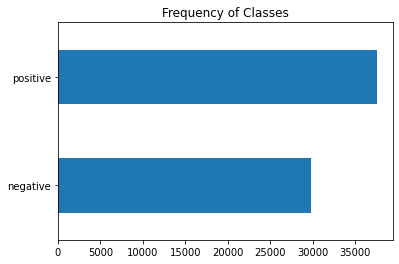

In [28]:

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [29]:
dataset.reset_format()

In [7]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.227000,0.299135,0.902523


TrainOutput(global_step=4210, training_loss=0.22696163146413703, metrics={'train_runtime': 22200.3658, 'train_samples_per_second': 3.034, 'train_steps_per_second': 0.19, 'total_flos': 1124931260163912.0, 'train_loss': 0.22696163146413703, 'epoch': 1.0})

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [11]:
preds_output = trainer.predict(encoded_dataset["validation"])

In [12]:
preds_output.metrics

{'test_loss': 0.29913508892059326,
 'test_accuracy': 0.9025229357798165,
 'test_runtime': 74.8443,
 'test_samples_per_second': 11.651,
 'test_steps_per_second': 0.735}

In [14]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [15]:
# Convert our dataset back to PyTorch tensors
encoded_dataset.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
encoded_dataset["validation"] = encoded_dataset["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/55 [00:00<?, ?ba/s]

In [17]:
encoded_dataset.set_format("pandas")
cols = ["sentence", "label", "predicted_label", "loss"]
df_test = encoded_dataset["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))
df_test.sort_values("loss", ascending=False).head(10)

,sentence,label,predicted_label,loss
791,it 's somewhat clumsy and too lethargically pa...,negative,positive,6.273899
519,moretti 's compelling anatomy of grief and the...,negative,positive,5.924835
95,this riveting world war ii moral suspense stor...,negative,positive,5.869769
494,"it showcases carvey 's talent for voices , but...",negative,positive,5.281095
112,hilariously inept and ridiculous .,positive,negative,5.143823
832,manages to show life in all of its banality wh...,negative,positive,5.122107
646,"the longer the movie goes , the worse it gets ...",negative,positive,4.933453
656,"so much facile technique , such cute ideas , s...",positive,negative,4.711403
695,"sit through this one , and you wo n't need a m...",negative,positive,4.560417
292,the story and the friendship proceeds in such ...,negative,positive,4.538715


Hyperparameter Search

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

Downloading trained model from huggingface hub

In [9]:
from transformers import pipeline

model_id = "distilbert-base-uncased-finetuned-sst2" #will need to update once trainer is done
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_sentence1 = "This movie did what it set out to do, perfectly... and maybe even a little better than perfect."
preds = classifier(custom_sentence1, return_all_scores=True)

results = classifier([custom_sentence1,custom_sentence2])
for result in results:
  print(result)

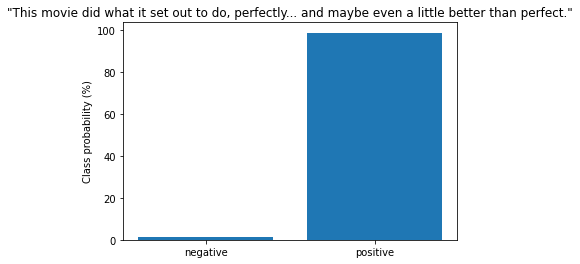

In [25]:
labels = encoded_dataset["train"].features["label"].names

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_sentence1}"')
plt.ylabel("Class probability (%)")
plt.show()